# Importar las librerías (deben de estar previamente instaladas)

In [316]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import kagglehub
from sklearn.model_selection import train_test_split, cross_val_score

# Importamos modelos a evaluar cual es mejor

In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Descargar herramientas para NLP

In [ ]:
# stopwords (elimina palabras vacias) y WordNetLemmatizer(lematización de palabras en un texto - La lematización es el proceso de reducir una palabra a su forma base o raíz)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jisaza53\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jisaza53\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Cargamos los datos - KAGGLE (API)

In [295]:
# Download latest version
path = kagglehub.dataset_download("cynthiarempel/amazon-us-customer-reviews-dataset")

In [296]:
# Obtener la lista de archivos .tsv en el directorio
tsv_files = [f for f in os.listdir(path) if f.endswith('.tsv')]

# Lista para almacenar los DataFrames
df_list = []

cols = ['marketplace','product_title','product_category','verified_purchase','review_headline','review_date']

# Leer cada archivo .tsv y añadirlo a la lista de DataFrames
for file in tsv_files:
    file_path = os.path.join(path, file)
    print(f"Leyendo archivo: {file_path}")
    
    # Leer el archivo .tsv en un DataFrame (ignorar las líneas mal formateadas)
    try:
        df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip',usecols=cols,nrows=70000)
        df_list.append(df)
    except Exception as e:
        print(f"Error al leer el archivo {file}: {e}")

# Concatenar todos los DataFrames en uno solo
final_df = pd.concat(df_list, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
print(final_df.head(5))

Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\datasets\cynthiarempel\amazon-us-customer-reviews-dataset\versions\9\amazon_reviews_multilingual_US_v1_00.tsv
Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\datasets\cynthiarempel\amazon-us-customer-reviews-dataset\versions\9\amazon_reviews_us_Apparel_v1_00.tsv
Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\datasets\cynthiarempel\amazon-us-customer-reviews-dataset\versions\9\amazon_reviews_us_Automotive_v1_00.tsv
Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\datasets\cynthiarempel\amazon-us-customer-reviews-dataset\versions\9\amazon_reviews_us_Baby_v1_00.tsv
Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\datasets\cynthiarempel\amazon-us-customer-reviews-dataset\versions\9\amazon_reviews_us_Beauty_v1_00.tsv
Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\datasets\cynthiarempel\amazon-us-customer-reviews-dataset\versions\9\amazon_reviews_us_Books_v1_02.tsv
Leyendo archivo: C:\Users\jisaza53\.cache\kagglehub\data

In [297]:
final_df.head(5)

,marketplace,product_title,product_category,verified_purchase,review_headline,review_date
0,US,The Sandman Vol. 1: Preludes and Nocturnes,Books,N,ignore the review below,1995-08-13
1,US,The 22 Immutable Laws of Marketing,Books,N,awesome,1995-08-17
2,US,Contact,Books,N,Read the book. It's good.,1995-08-30
3,US,Good Omens,Books,N,Funniest book ever written about the Anti-Christ,1995-09-11
4,US,A Confederacy of Dunces,Books,N,A winner that didn't last. Only a mothers love...,1995-10-17


# Organizamos la información del  las reseñas (Calidad del dato)

In [ ]:
# Preprocesar el texto stop(stopwords - Elimina los espacios en blanco y WordNetLemmatizer - que corta palabras hasta obtener una raíz )
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):  # Si el texto no es una cadena (e.g., NaN o float), lo convertimos en vacío
        return ''
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Eliminar caracteres especiales
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Creamos un dataframe donde se contenga las clasificaciones para analizar 

In [299]:
try:
    feeling = pd.read_excel(r'C:\Users\jisaza53\OneDrive - Cementos Argos S.A\Escritorio\PruebaTecnica_GestorSr\DataSet\Feelings.xlsx',header=0)
except Exception as e:
    print(f"Error al leer el archivo: {e}")

Error al leer el archivo: [Errno 13] Permission denied: 'C:\\Users\\jisaza53\\OneDrive - Cementos Argos S.A\\Escritorio\\PruebaTecnica_GestorSr\\DataSet\\Feelings.xlsx'


In [300]:
feeling['cleaned_review'] = feeling['review_headline'].apply(preprocess_text)

In [301]:
# Codificar la columna 'sentiment' a etiquetas numéricas
sentiment_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
feeling['sentiment_label'] = feeling['sentiment'].map(sentiment_mapping)

In [302]:
feeling.head()

,review_headline,sentiment,cleaned_review,sentiment_label
0,"Great product, would buy again!",positive,great product would buy,0
1,Worst purchase ever,negative,worst purchase ever,2
2,"Not bad, but could be better",neutral,bad could better,1
3,Absolutely love this!,positive,absolutely love,0
4,I’m disappointed with the quality,negative,im disappointed quality,2


1.4 Tokenización y vectorización

In [303]:
# Inicializar el vectorizador
vectorizer = TfidfVectorizer(max_features=5000)

# Convertir las reseñas en vectores
X = vectorizer.fit_transform(feeling['cleaned_review'])
y = feeling['sentiment_label']

2.1 División del conjunto de datos

In [304]:
# Dividir en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Comparamos los modelos

In [305]:

# Create a dictionary of models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': MultinomialNB(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Hyperparameter tuning (optional, but recommended)
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Naive Bayes': {},  # No hyperparameters to tune for Naive Bayes
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]}
}

# Train and evaluate each model with cross-validation
for model_name, model in models.items():
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("--------------------------------------------------")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.50      0.67         2
           2       1.00      0.50      0.67         4

    accuracy                           0.83        18
   macro avg       0.93      0.67      0.74        18
weighted avg       0.87      0.83      0.81        18

Accuracy: 0.8333333333333334
--------------------------------------------------
Model: Random Forest
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       1.00      0.50      0.67         2
           2       0.67      0.50      0.57         4

    accuracy                           0.78        18
   macro avg       0.82      0.64      0.69        18
weighted avg       0.78      0.78      0.77        18

Accuracy: 0.7777777777777778
--------------------------------------------------
Model: Support Vector Machine


c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jisaza53\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

2.2 Entrenar el modelo seleccionado

In [306]:

# Inicializar y entrenar el modelo
modelo = KNeighborsClassifier(n_neighbors=5)  # Aquí puedes ajustar el parámetro 'n_neighbors' según sea necesario

# Entrenar el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.50      0.67         2
           2       1.00      0.25      0.40         4

    accuracy                           0.78        18
   macro avg       0.92      0.58      0.64        18
weighted avg       0.83      0.78      0.73        18



# Procesamos los set de datos de Kaggle

In [307]:
# Aplicar preprocesamiento a la columna 'review_headline' (puede variar dependiendo del nombre de la columna)
final_df['cleaned_review'] = final_df['review_headline'].apply(preprocess_text)

# Verificar resultados
final_df[['review_headline', 'cleaned_review']].head()

,review_headline,cleaned_review
0,ignore the review below,ignore review
1,awesome,awesome
2,Read the book. It's good.,read book good
3,Funniest book ever written about the Anti-Christ,funniest book ever written antichrist
4,A winner that didn't last. Only a mothers love...,winner didnt last mother love remained


In [308]:
X_df = vectorizer.transform(final_df['cleaned_review'])

# Realizamos la proyección

In [309]:
predicciones = modelo.predict(X_df)

In [310]:
predicciones

array([0, 0, 0, ..., 0, 0, 2], dtype=int64)

In [311]:
# Mapear las predicciones a sus etiquetas originales (si es necesario)
sentiment_mapping_reverse = {0: 'positive', 1: 'neutral', 2: 'negative'}
final_df['predicted_sentiment'] = [sentiment_mapping_reverse.get(pred, 'unknown') for pred in predicciones]


In [312]:
final_df.count()

marketplace            2590000
product_title          2589999
product_category       2590000
verified_purchase      2589993
review_headline        2589944
review_date            2589962
cleaned_review         2590000
predicted_sentiment    2590000
dtype: int64

In [314]:
# # Guardar las predicciones en un archivo Excel
# output_path = r'C:\Users\jisaza53\OneDrive - Cementos Argos S.A\Escritorio\PruebaTecnica_GestorSr\predicciones.xlsx'  # Cambia la ruta donde quieres guardar el archivo
# try:
#     with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
#         newDF.to_excel(writer,sheet_name='Proceso', index=False)  # Guardar el dataframe en un archivo Excel
#     print(f"Predicciones guardadas en: {output_path}")
# except Exception as e:
#     print(f"Error al guardar el archivo: {e}")

In [315]:
final_df.head()

,marketplace,product_title,product_category,verified_purchase,review_headline,review_date,cleaned_review,predicted_sentiment
0,US,The Sandman Vol. 1: Preludes and Nocturnes,Books,N,ignore the review below,1995-08-13,ignore review,positive
1,US,The 22 Immutable Laws of Marketing,Books,N,awesome,1995-08-17,awesome,positive
2,US,Contact,Books,N,Read the book. It's good.,1995-08-30,read book good,positive
3,US,Good Omens,Books,N,Funniest book ever written about the Anti-Christ,1995-09-11,funniest book ever written antichrist,positive
4,US,A Confederacy of Dunces,Books,N,A winner that didn't last. Only a mothers love...,1995-10-17,winner didnt last mother love remained,negative


# Insights

In [320]:
sentiment_counts = final_df.groupby(['product_title', 'predicted_sentiment']).size().unstack(fill_value=0)

Se recomienda una tabla de datos con los diferentes productos y el conteo de los sentimientos generados por los clientes, para realizar un analisis individual (Se recomienda revisar los que tengan mas de 5 comentarios para ser generador de valor)

In [321]:
sentiment_counts

predicted_sentiment,negative,neutral,positive
product_title,,,
"30-INCH"""" SKK-BB stacking kit for """"30 INCH"""" wide front load laundry pairs",0,0,2
BODY by Designer Skin New 2013 16 oz Advanced Silicone Tan Extender,0,0,1
Bo Knows Bo The Bo Jackson Story,0,1,0
Ion Block Rocker Explorer Sound System w/ Bluetooth (Blue),0,0,1
NO PUBLIC RESTROOMS sign door signs business restaurant office warning plastic commercial cafe bathroom,1,0,0
...,...,...,...
너희들은 포위됐다 You're All Surrounded (Music from the Original TV Series),0,0,1
"눈, 코, 입 Eyes, Noes, Lips",0,0,1
링가링가 Ringa Linga,1,0,0


-	Nos permite evidenciar cuanto fue la proporción por las reseñas realizadas respecto a las compras verificadas

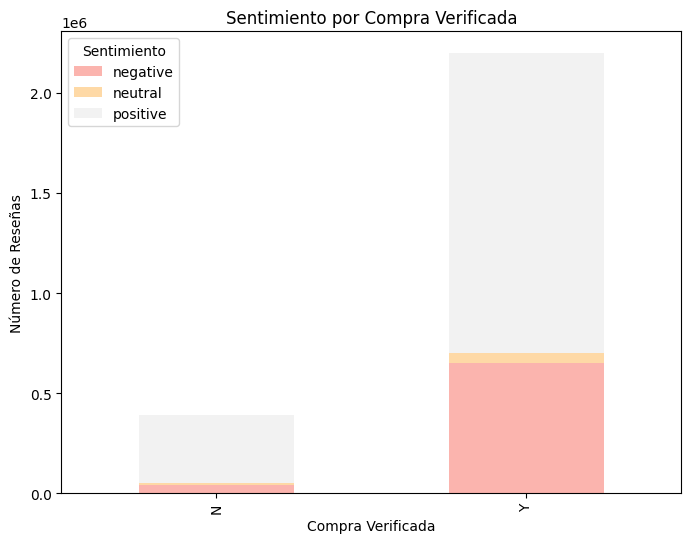

In [322]:
# Sentimiento por compra verificada
verified_sentiment = final_df.groupby(['verified_purchase', 'predicted_sentiment']).size().unstack().fillna(0)

# Visualización
verified_sentiment.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Pastel1')
plt.title('Sentimiento por Compra Verificada')
plt.xlabel('Compra Verificada')
plt.ylabel('Número de Reseñas')
plt.legend(title='Sentimiento')
plt.show()

-	Arroja comportamientos de los clientes respecto a los productos y nos permite ver cuales son los productos mas comentados y podría decirse (hay que realizar un analisis mas profundo) que los productos más solicitados

C:\Users\jisaza53\AppData\Local\Temp\ipykernel_28576\458406194.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_review_counts.index, y=category_review_counts.values, palette='muted')


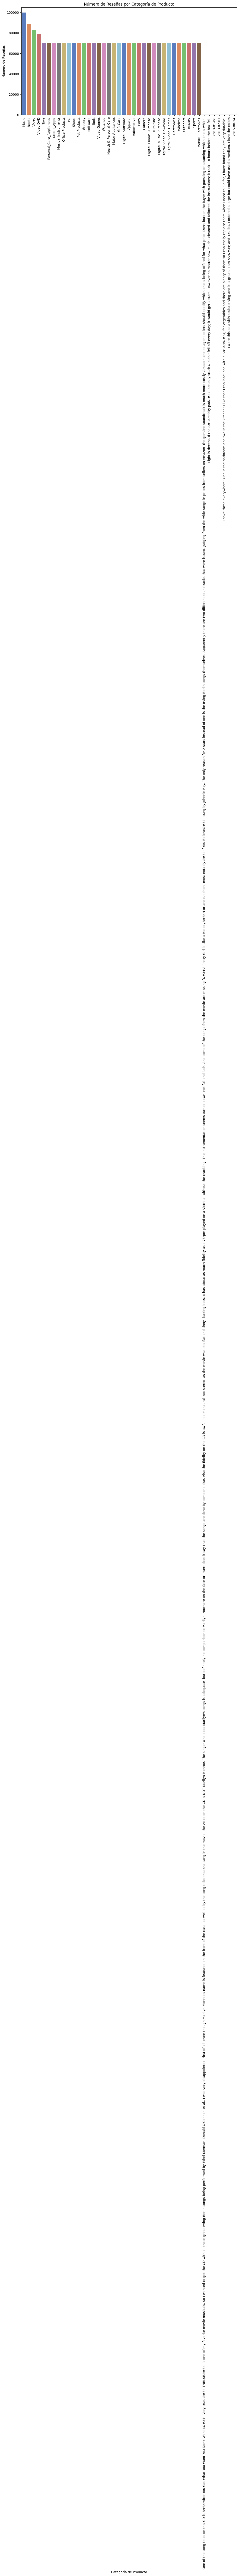

In [324]:
# Número de reseñas por categoría
category_review_counts = final_df['product_category'].value_counts()

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x=category_review_counts.index, y=category_review_counts.values, palette='muted')
plt.title('Número de Reseñas por Categoría de Producto')
plt.xlabel('Categoría de Producto')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=90)
plt.show()

-	Nos permite ver cuales son los productos que mas han gustado y con una análisis mas profundo podemos ver porque, para replicarlo en otros productos semejantes (SE RECOMIENDA ALGORITMO DE CLUSTERIZACIÓN)

C:\Users\jisaza53\AppData\Local\Temp\ipykernel_28576\4257820892.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_positive_reviews.index, y=product_positive_reviews.values, palette='Blues_d')


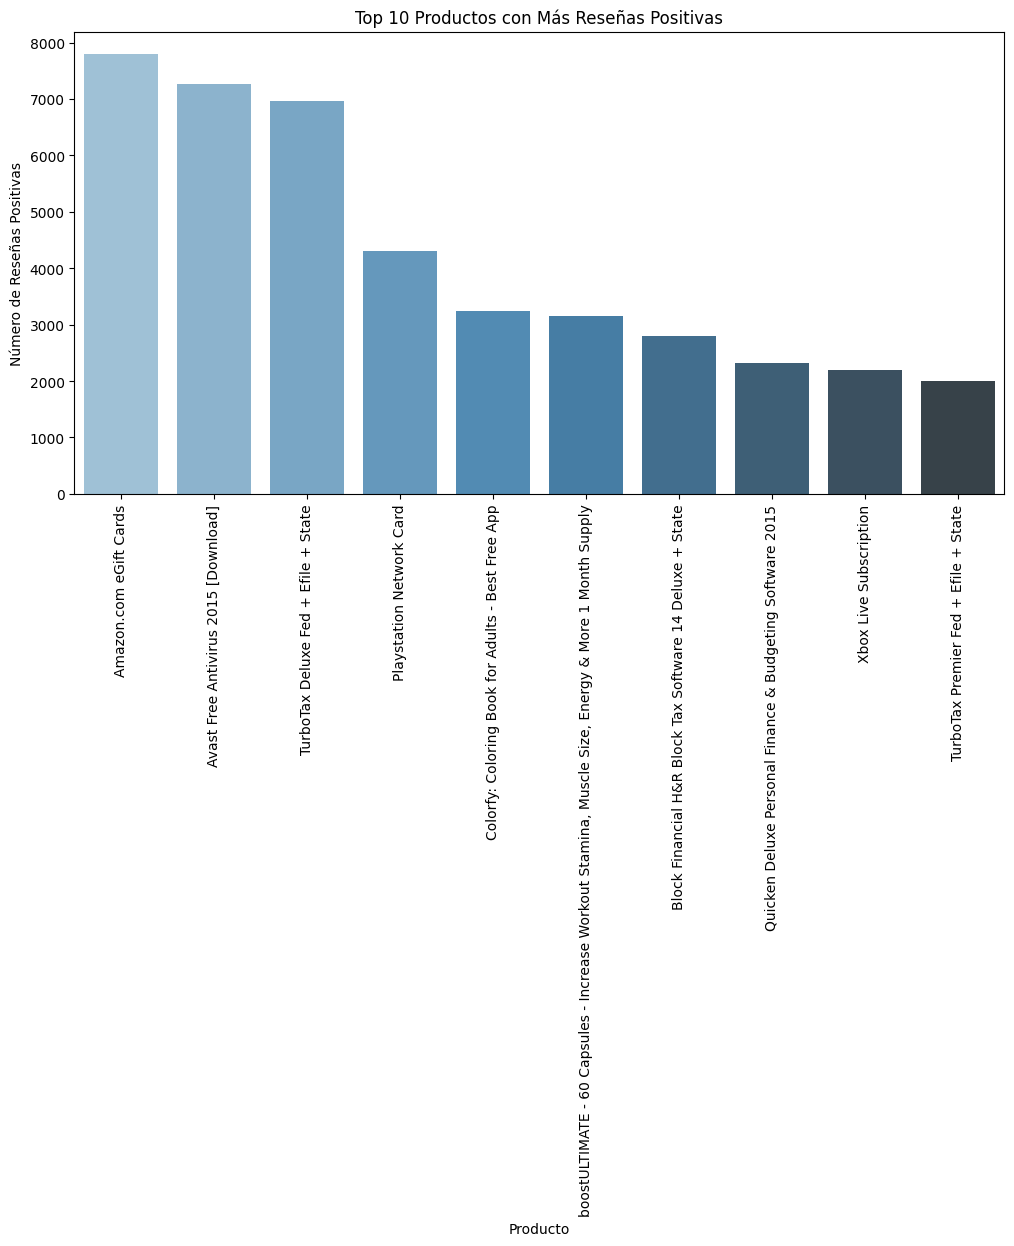

In [325]:
# Número de reseñas positivas por producto
positive_reviews = final_df[final_df['predicted_sentiment'] == 'positive']
product_positive_reviews = positive_reviews.groupby('product_title').size().sort_values(ascending=False).head(10)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x=product_positive_reviews.index, y=product_positive_reviews.values, palette='Blues_d')
plt.title('Top 10 Productos con Más Reseñas Positivas')
plt.xlabel('Producto')
plt.ylabel('Número de Reseñas Positivas')
plt.xticks(rotation=90)
plt.show()

-	Nos lleva a realizar analisis muy chéveres sobre los productos que mas reseñas negativas han tenido, se recomienda realizar ponderaciones para los cálculos y algoritmos para revisar mayor detalle.

C:\Users\jisaza53\AppData\Local\Temp\ipykernel_28576\636190982.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_positive_reviews.index, y=product_positive_reviews.values, palette='PiYG')


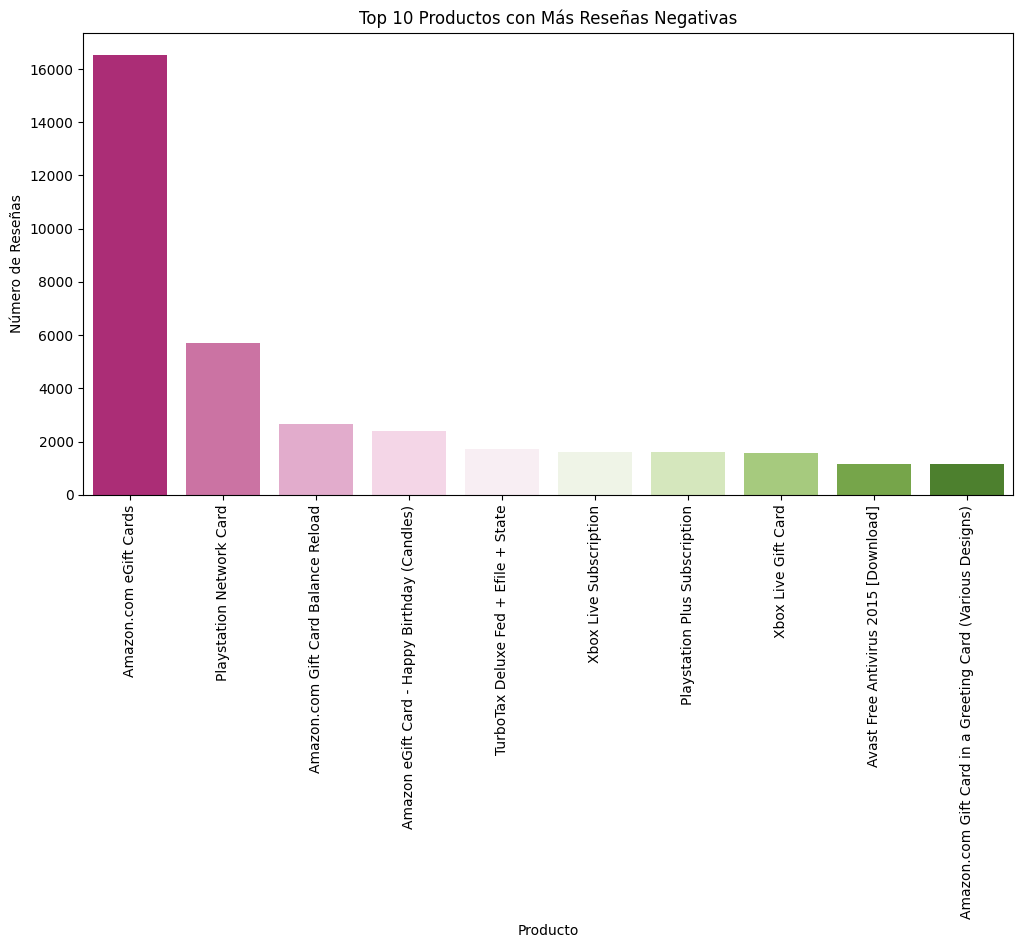

In [329]:
# Número de reseñas positivas por producto
positive_reviews = final_df[final_df['predicted_sentiment'] == 'negative']
product_positive_reviews = positive_reviews.groupby('product_title').size().sort_values(ascending=False).head(10)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x=product_positive_reviews.index, y=product_positive_reviews.values, palette='PiYG')
plt.title('Top 10 Productos con Más Reseñas Negativas')
plt.xlabel('Producto')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=90)
plt.show()

-	Al realizar esta analisis por tiempos en mes, podemos evidenciar como han sido aplicados los comentarios con el pasar del tiempo y que meses tenemos mayor flujo de compras, también en que meses hemos tenido mayores reseñas dependiendo su tipo.

predicted_sentiment  negative  neutral  positive
month_name                                      
January                 15148     1530     52272
February                14441     1524     50438
March                   13489     1586     48711
April                   10016     1208     38774
May                     10157     1150     37064
June                    16466     1753     56875
July                    81997     5919    183402
August                 491064    35029   1111453
September               10592     2727    140643
October                  9972     1251     49976
November                 8580      969     28629
December                11717     1329     42005


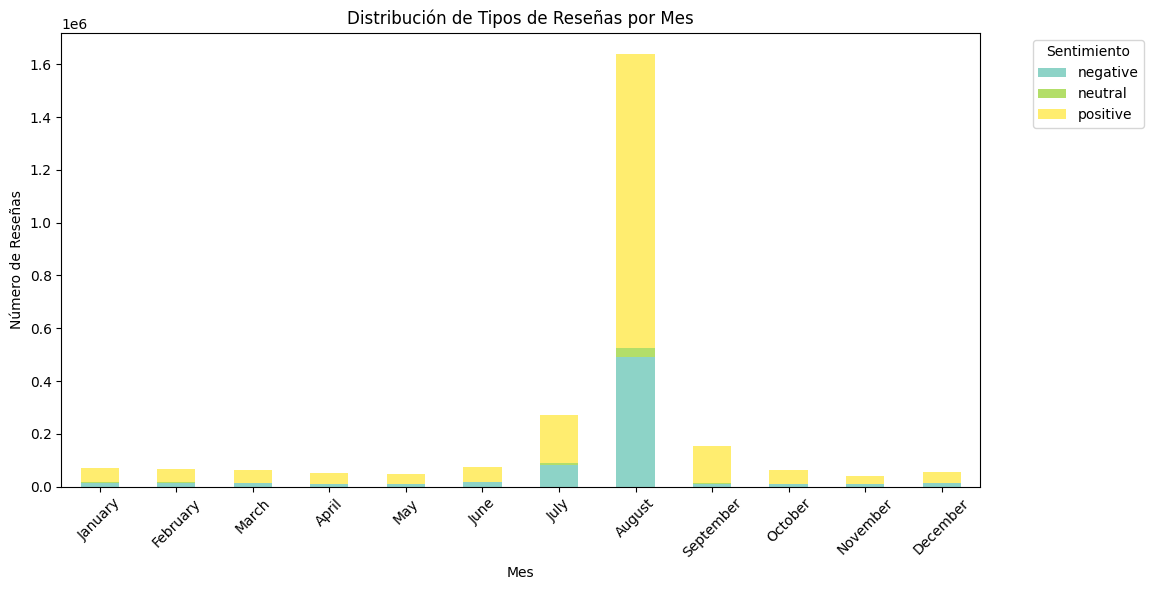

In [336]:
# Convertir la columna 'review_date' a formato de fecha
final_df['review_date'] = pd.to_datetime(final_df['review_date'], errors='coerce')

# Crear una nueva columna con el mes (numerado del 1 al 12)
final_df['month'] = final_df['review_date'].dt.month

# Crear una nueva columna con el nombre del mes
final_df['month_name'] = final_df['review_date'].dt.strftime('%B')

# Asegúrate de que la columna 'predicted_sentiment' esté presente (si no, ajusta el nombre)
if 'predicted_sentiment' not in final_df.columns:
    print("La columna 'predicted_sentiment' no está en el DataFrame.")
else:
    # Agrupar por 'month_name' y 'predicted_sentiment', y contar el número de reseñas
    monthly_sentiment_counts = final_df.groupby(['month_name', 'predicted_sentiment']).size().unstack(fill_value=0)

    # Asegurarse que los meses estén en el orden correcto
    months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December']
    
    # Reordenar las filas de la tabla para que aparezcan los meses en el orden correcto
    monthly_sentiment_counts = monthly_sentiment_counts.reindex(months_order)

    # Mostrar la tabla resultante
    print(monthly_sentiment_counts)

    # Graficar los resultados
    monthly_sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
    plt.title('Distribución de Tipos de Reseñas por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Número de Reseñas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title="Sentimiento", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()